In [448]:
import random

import numpy as np

from Petri.utils import _return_all_neighboring_locs, _draw, _return_neighboring_unoccupied_locs, _move, _return_neighboring_occupied_locs, _find_connected_components, _sample, _return_random_loc, summarize
from Petri.simulator import simulator

In [575]:
def _scatter(curr_loc, env):
    free_locs = _return_neighboring_unoccupied_locs(curr_loc, env)
    if free_locs:
        next_loc = random.choice(free_locs)
        _move(curr_loc, next_loc, env[curr_loc], env)
        
def _replicate(curr_loc, env):
    neighbors = _return_neighboring_occupied_locs(curr_loc, env)
    if neighbors:
        for neighbor in neighbors:
            if env[neighbor][0] == 2:  # res is id 2
                env[neighbor] = env[curr_loc]

In [576]:
def Dreg(curr_loc, env):
    """id 1"""
    
    # do something to a neighbor slot
    neighboring_locs = _return_all_neighboring_locs(curr_loc, env)
    neighbor = random.choice(neighboring_locs)

    if neighbor not in env.keys():
        if _draw(.1):  # create res with 30% chance
            env[neighbor] = (2, None)
        elif _draw(.01):  # or create a new dreg with 1% chance
            env[neighbor] = (1, None)
        else:
            pass
    
    # if dreg is next to a occupied slot, randomly destroy neighborhood
    else:
        if _draw(.2):
            neighbors = _return_neighboring_occupied_locs(curr_loc, env)
            for neighbor in neighbors:
                env.pop(neighbor)

    # move to an unoccupied slot (or stay put if there are no unoccupied slots)
    open_locs = _return_neighboring_unoccupied_locs(curr_loc, env)
    if open_locs:
        next_loc = random.choice(open_locs)
        e = (1, None)
        _move(curr_loc, next_loc, e, env)
    else:
        pass

    
def Res(curr_loc, env):
    """id 2"""
    # scatter
    if _draw(0.2):
        _scatter(curr_loc, env)
        

def Data(curr_loc, env):
    """id 8"""
    _replicate(curr_loc, env)
            

def Sorter(curr_loc, env):
    """id 5
    """
    # step 0 - replicate
    _replicate(curr_loc, env)
    
    # step 1 - if theres data, move it left or right of the channel
    neighbors = _return_neighboring_occupied_locs(curr_loc, env)
    if neighbors:
        for neighbor in neighbors:
            if env[neighbor][0] == 8:  # data has id 8
                
                # cache hit, so move data left
                if env[neighbor][1] == env[curr_loc][1]:
                    data_element = env[neighbor]
                    next_loc = (neighbor[0], neighbor[1] - 5)
                    _move(neighbor, next_loc, data_element, env)
                    
                    # cache hit so infect neighboring sorters
                    neighbors = _return_neighboring_occupied_locs(curr_loc, env)
                    if neighbors:
                        for neighbor in neighbors:
                            if env[neighbor][0] == 5:
                                env[neighbor] = env[curr_loc]
                                
                else:
                    data_element = env[neighbor]
                    next_loc = (neighbor[0], neighbor[1] + 5)
                    _move(neighbor, next_loc, data_element, env)
                    
                                
    # step 3 scatter
    _scatter(curr_loc, env)


def Query(curr_loc, env):
    """id 10
    """
    arr = env[curr_loc][1]
    request = np.random.choice(arr, p=[0.6, 0.25, 0.1, 0.05])
    
    # broadcast to sorters
    neighbors = _return_neighboring_occupied_locs(curr_loc, env)
    if neighbors:
        for neighbor in neighbors:
            if env[neighbor][0] == 5:  # sorters is id5
                env[neighbor] = (5, request)
                
    # scatter
    _scatter(curr_loc, env)

In [577]:
def create_LRU(n_rows, n_cols, n_query, n_dregs, n_sorters, arr):
    world = {}
    world['n_rows'] = n_rows
    world['n_cols'] = n_cols
            
    # create dregs (represented by id 1)
    for _ in range(n_dregs):
        loc = _return_random_loc(n_rows, n_cols)
        world[loc] = (1, None)
        
    # create sorter (represented by id 5)
    for _ in range(n_sorters):
        loc = _return_random_loc(n_rows, n_cols)
        val = np.random.choice(arr)
        world[loc] = (5, val)
    
    # create data (represented by id 8)
    for _ in range(30):
        for a in arr:
            loc = _return_random_loc(n_rows, n_cols)
            world[loc] = (8, a)
        
    # query is id 10
    for _ in range(n_query): 
        loc = _return_random_loc(n_rows, n_cols)
        world[loc] = (10, arr)
        
    return world

In [578]:
ARR = ["A", "B", "C", "D"]

In [579]:
loop = {10: Query, 8: Data, 5: Sorter, 1: Dreg, 2: Res}

n_rows = 20
n_cols = 60
epochs = 100000
ENV = create_LRU(n_rows=n_rows, n_cols=n_cols, n_query=50, n_dregs=5, n_sorters=100, arr=ARR)
CANVASS = np.zeros((n_rows, n_cols))

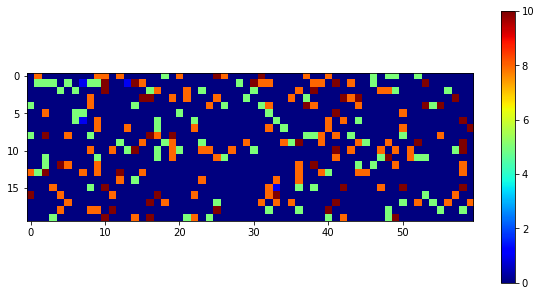

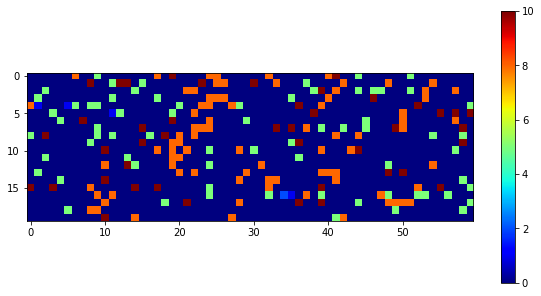

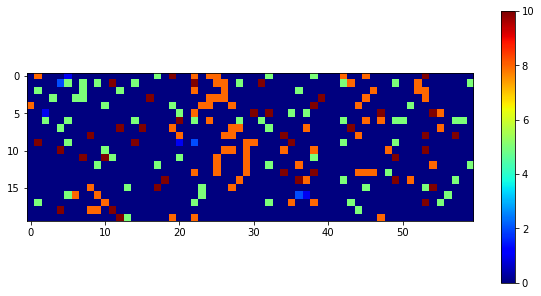

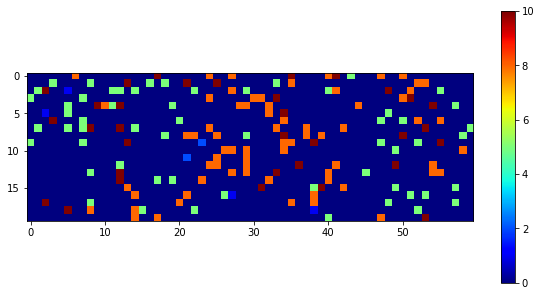

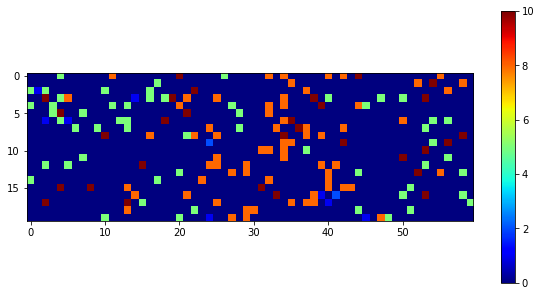

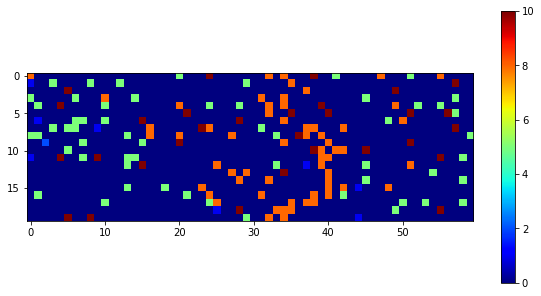

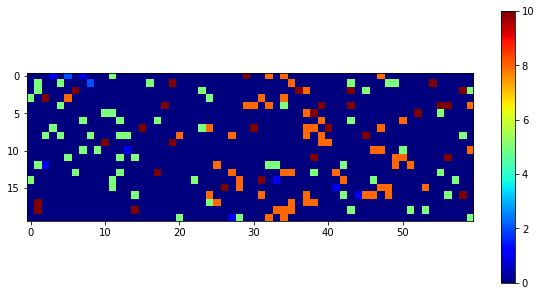

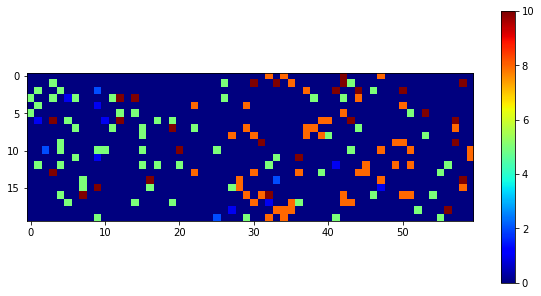

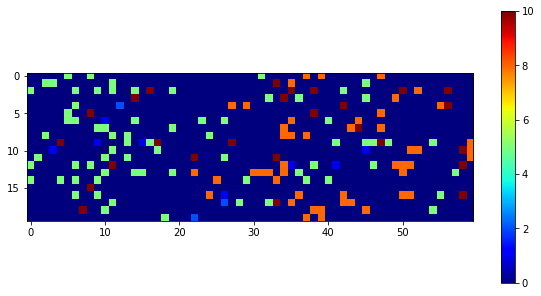

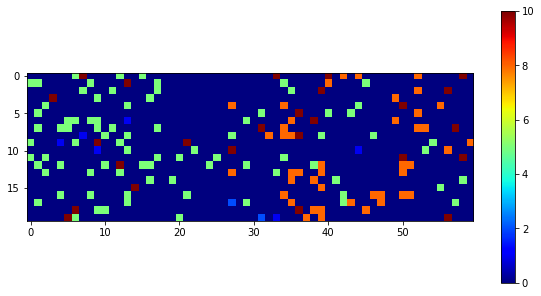

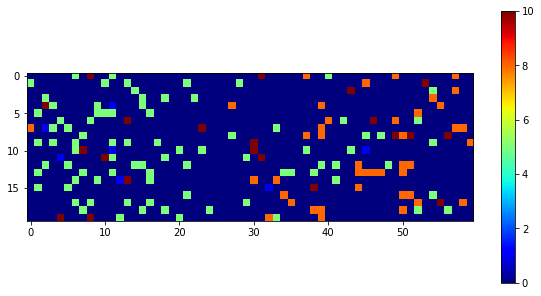

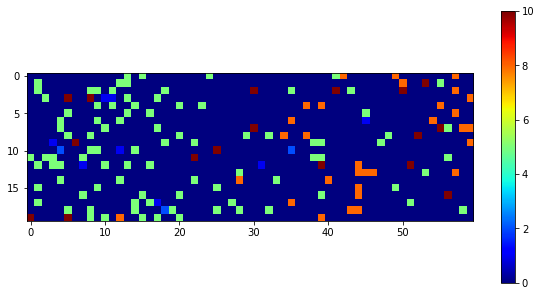

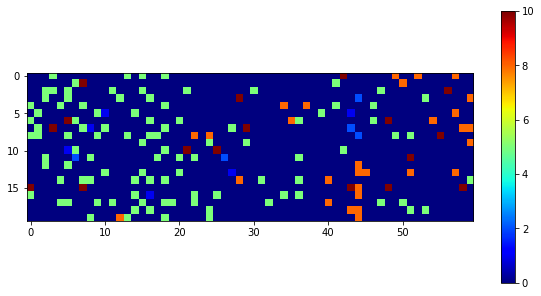

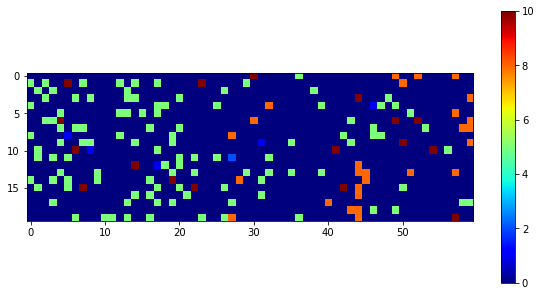

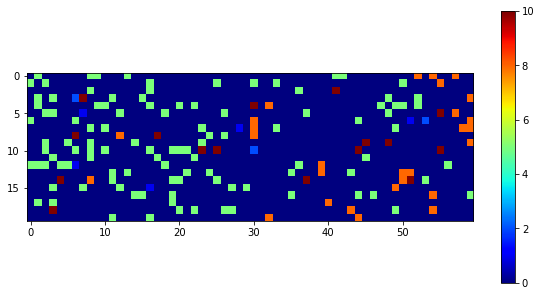

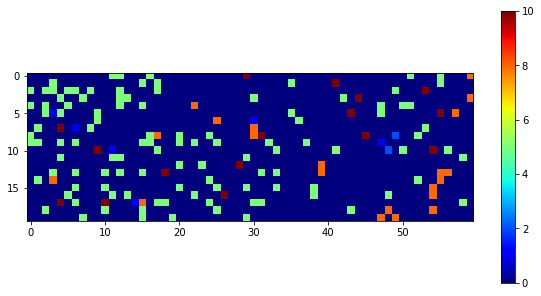

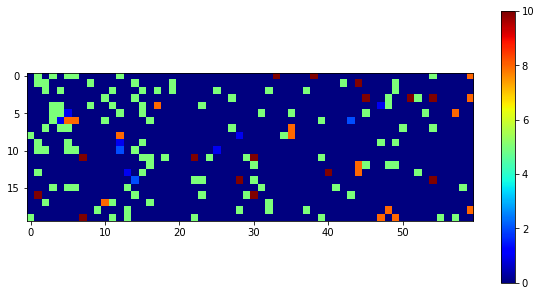

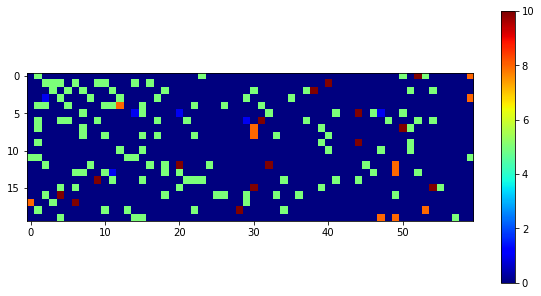

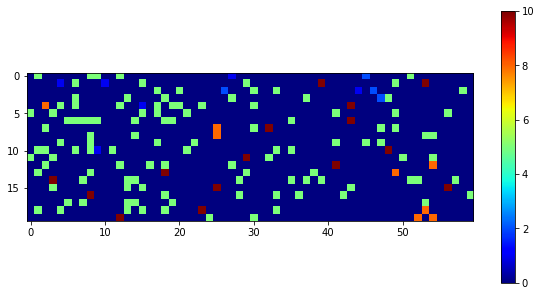

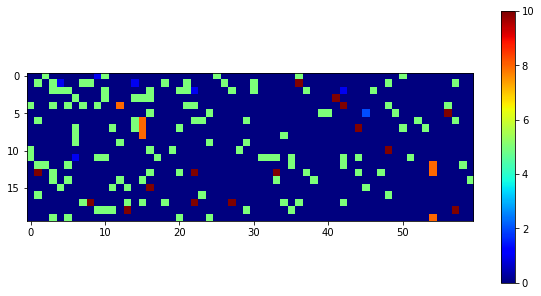

In [580]:
simulator(ENV, CANVASS, epochs, loop, frames=20, save=False)

In [589]:
# we want data elements on the left side of the board

keep = []
for k in ENV.keys():
    if isinstance(k, tuple):
        if k[1] < 20 and ENV[k][0] == 8:  # data is id8
            keep.append(k)

In [590]:
counter = {}

for k in keep:
    element = ENV[k]
    if element[1] not in counter.keys():
        counter[element[1]] = 1
    else:
        counter[element[1]] += 1
counter

{'B': 1, 'A': 19}